# Lattice Fuel study with OpenMC

## Loading Libraires, materials and homemade openMC functions


In [2]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np


CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, WATER_MATERIAL
from src.utils.pre_processing.pre_processing import (remove_previous_results, parallelepiped, plot_geometry, mesh_tally_xy, mesh_tally_yz, 
                                                     dammage_energy_mesh_xy, dammage_energy_mesh_yz)
from src.utils.post_preocessing.post_processing import load_mesh_tally, load_dammage_energy_tally
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS


In [ ]:

material = openmc.Materials([FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, WATER_MATERIAL])
material.export_to_xml()

In [4]:
r_pin_fuel = openmc.ZCylinder(r=3.5)
pin_fuel_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-r_pin_fuel)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+r_pin_fuel)
pin_universe = openmc.Universe(cells=(pin_fuel_fuel_cell, graphite_cell))

r_big_pin_fuel = openmc.ZCylinder(r=5.5)
big_pin_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-r_big_pin_fuel)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+r_big_pin_fuel)
big_pin_universe = openmc.Universe(cells=(big_pin_fuel_cell, graphite_cell))

pin_helium_cell = openmc.ZCylinder(r=1., boundary_type='vacuum')
helium_cell = openmc.Cell(fill=HELIUM_MATERIAL, region=-pin_helium_cell)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+pin_helium_cell)
pin_helium_universe = openmc.Universe(cells=(helium_cell, graphite_cell))

all_graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL)
outer_universe = openmc.Universe(cells=(all_graphite_cell,))

lat = openmc.HexLattice()
lat.center = (0., 0.)
lat.pitch = (12.5,)   # pitch en cm
lat.outer = outer_universe

lat.universes = [
    [pin_helium_universe] * 24, # 5th ring
    [big_pin_universe] * 18,    # 4th ring    
    [pin_universe] * 12,        # 3rd ring
    [big_pin_universe] * 6,     # 2nd ring
    [big_pin_universe]          # 1st ring
]   

outer_surface = openmc.ZCylinder(r=65.)
steel_outer_surface = openmc.ZCylinder(r=75.)  # 1 cm thickness around graphite
height_top_active_part = openmc.ZPlane(z0=100.0)
height_bottom_active_part = openmc.ZPlane(z0=-100.0)

In [7]:
# Main cell: lattice inside graphite cylinder
main_cell = openmc.Cell(
    fill=lat,
    region=(-outer_surface & -height_top_active_part & +height_bottom_active_part)
)

# Steel shell cell: between graphite and steel cylinder
steel_shell_region = (+outer_surface & -steel_outer_surface & -height_top_active_part & +height_bottom_active_part)
steel_shell_cell = openmc.Cell(fill=STEEL_MATERIAL, region=steel_shell_region)

outer_sphere = openmc.Sphere(r=1000.0, boundary_type='vacuum')

# Air region above the cylinder
air_region_above = -outer_sphere & -height_top_active_part
air_cell_above = openmc.Cell(fill=AIR_MATERIAL, region=air_region_above)

# Air region below the cylinder
air_region_below = -outer_sphere & +height_bottom_active_part
air_cell_below = openmc.Cell(fill=AIR_MATERIAL, region=air_region_below)

# Air region surrounding the steel cylinder (radially outside)
air_region_side = -outer_sphere & +steel_outer_surface & -height_top_active_part & +height_bottom_active_part
air_cell_side = openmc.Cell(fill=AIR_MATERIAL, region=air_region_side)

geometry = openmc.Geometry([main_cell, steel_shell_cell, air_cell_above, air_cell_below, air_cell_side])


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

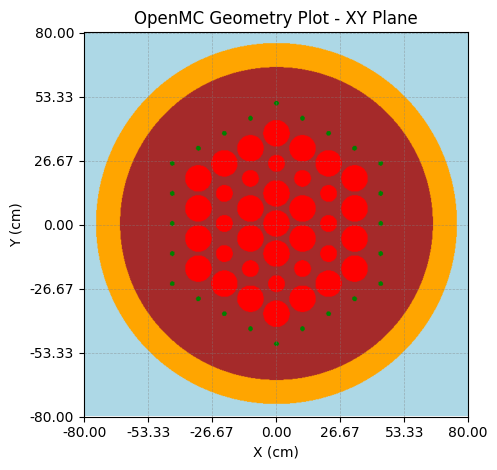

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

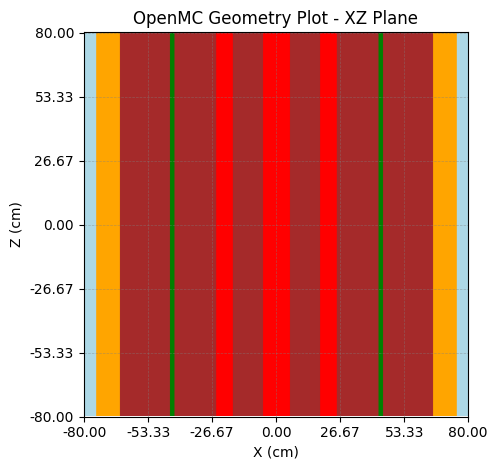

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

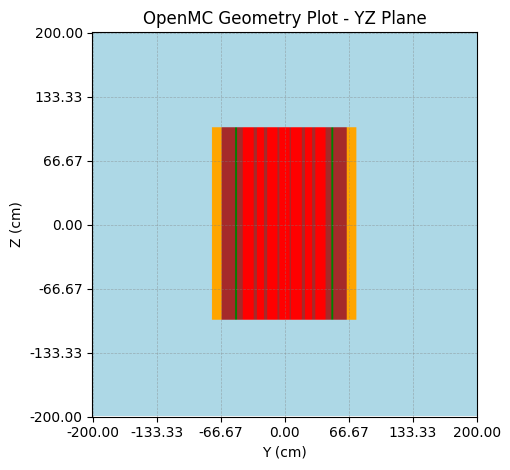

In [8]:

geometry.export_to_xml()

plot_geometry(materials = material, plane="xy", width=160, height=160)

plot_geometry(materials = material, plane="xz", width=160, height=160)

plot_geometry(materials = material, plane="yz", width=400, height=400)


In [9]:
settings = openmc.Settings()
batches_number= 100
settings.batches = batches_number
settings.inactive = 20
settings.particles = 100000
settings.source = openmc.Source()
settings.source.space = openmc.stats.Point((0, 0, 0))
settings.source.particle = 'neutron'
settings.photon_transport = True
settings.source.angle = openmc.stats.Isotropic()


/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [10]:
# tally pour le flux dans le détecteur
tally = openmc.Tally(name="flux_tally")
tally.scores = ['flux']
tally.filters = [openmc.CellFilter(main_cell)]

# Tally for fission rate
fission_tally = openmc.Tally(name="fission_rate_tally")
fission_tally.scores = ['fission']
fission_tally.filters = [openmc.CellFilter(main_cell)]

# Tally for nu-fission (nu * fission rate)
nu_fission_tally = openmc.Tally(name="nu_fission_rate_tally")
nu_fission_tally.scores = ['nu-fission']
nu_fission_tally.filters = [openmc.CellFilter(main_cell)]

tallies = openmc.Tallies([tally, fission_tally, nu_fission_tally])


In [11]:
mesh_tally_neutron_xy = mesh_tally_xy(name_mesh_tally = "flux_mesh_neutrons_xy", particule_type='neutron', 
                                      bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                      z_thickness= 10.0, z_value=0.0)
tallies.append(mesh_tally_neutron_xy)

mesh_tally_photon_xy = mesh_tally_xy(name_mesh_tally = "flux_mesh_photons_xy", particule_type='photon', 
                                     bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                     z_thickness= 10.0, z_value=0.0)
tallies.append(mesh_tally_photon_xy)

mesh_tally_neutron_yz = mesh_tally_yz(name_mesh_tally = "flux_mesh_neutrons_yz", particule_type='neutron', 
                                      bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), 
                                      x_thickness= 5.0, x_value=0.0)
tallies.append(mesh_tally_neutron_yz)

mesh_tally_photon_yz = mesh_tally_yz(name_mesh_tally = "flux_mesh_photons_yz", particule_type='photon', 
                                     bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                     x_thickness= 5.0, x_value=0.0)
tallies.append(mesh_tally_photon_yz)

dammage_energy_tally_xy = dammage_energy_mesh_xy(name_mesh_tally="dammage_energy_mesh_xy", bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), z_value=0.0, z_thickness=4.0)
tallies.append(dammage_energy_tally_xy)

dommage_energy_tally_yz = dammage_energy_mesh_yz(name_mesh_tally="dammage_energy_mesh_yz", bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), x_value=0.0, x_thickness=1.0)
tallies.append(dommage_energy_tally_yz)

In [12]:
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=7.
  warn(msg, IDWarning)


In [20]:
remove_previous_results(batches_number=batches_number)
openmc.run(threads=4)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [13]:
statepoint_file = openmc.StatePoint(f'statepoint.{batches_number}.h5')
tally = statepoint_file.get_tally(name="flux_tally")
mean_flux = tally.mean.flatten().tolist()
std_flux = tally.std_dev.flatten().tolist()
# Get fission rate and nu-bar
fission_tally_result = statepoint_file.get_tally(name="fission_rate_tally")
nu_fission_tally_result = statepoint_file.get_tally(name="nu_fission_rate_tally")

fission_rate = float(fission_tally_result.mean.flatten()[0])
nu_fission_rate = float(nu_fission_tally_result.mean.flatten()[0])
nu_bar = nu_fission_rate / fission_rate if fission_rate != 0 else float('nan')

In [15]:
from src.utils.common.materials_utils import get_mass_fraction
reactor_power = 5e6  # 5 MW in Watts

# Energy released per fission depends on isotope composition
# 19.75% U-235, 80.25% U-238 (by atom fraction)
# Typical energy per fission: U-235 = 202.5 MeV, U-238 = 205.0 MeV

fraction_u235 = get_mass_fraction(FUEL_MATERIAL, "U235")
fraction_u238 = get_mass_fraction(FUEL_MATERIAL, "U238")

energy_u235 = 202.5e6 * 1.60218e-19  # J
energy_u238 = 205.0e6 * 1.60218e-19  # J

# Weighted average energy per fission
energy_per_fission = fraction_u235 * energy_u235 + fraction_u238 * energy_u238

fissions_per_second = reactor_power / energy_per_fission
print(f"Fissions per second: {fissions_per_second:.2e}")

Fissions per second: 1.53e+17


In [16]:
print(f"Mean flux: {mean_flux}")
print(f"Standard deviation of flux: {std_flux}")
print(f"Fission rate: {fission_rate:.2e}")
print(f"Nu-fission rate: {nu_fission_rate:.2e}")
print(f"Nu-bar: {nu_bar:.2f}")

Mean flux: [136.16696887445502]
Standard deviation of flux: [0.03890222933621471]
Fission rate: 4.50e-01
Nu-fission rate: 1.13e+00
Nu-bar: 2.51


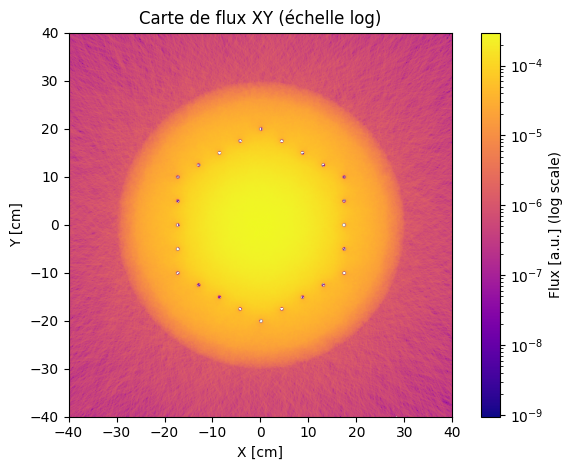

In [22]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_neutrons_xy",
                bin_number=500, lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), 
                plane="xy", saving_figure=False)


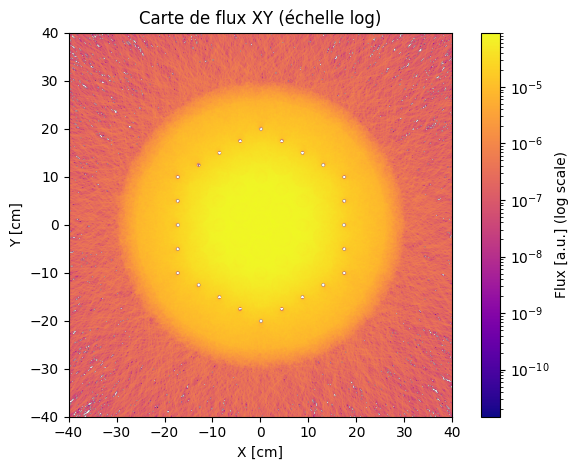

In [23]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_photons_xy",
            bin_number=500, lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), 
            plane="xy", saving_figure=False)


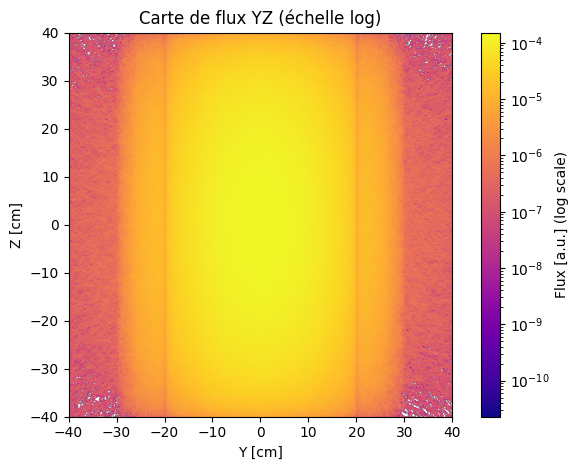

In [24]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_neutrons_yz", bin_number=500,
                lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), plane="yz", 
                saving_figure=False)


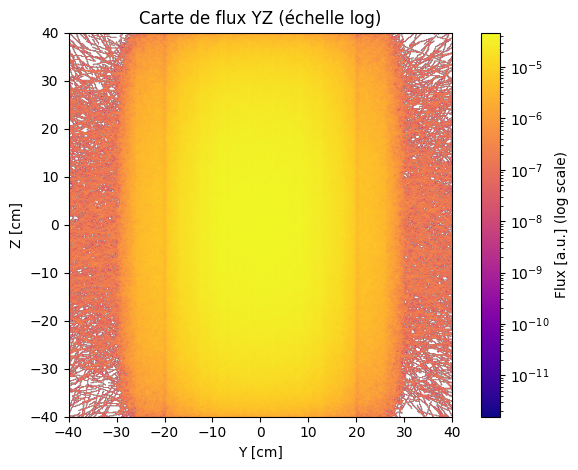

In [25]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_photons_yz", bin_number=500,
                lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), plane="yz", 
                saving_figure=False)


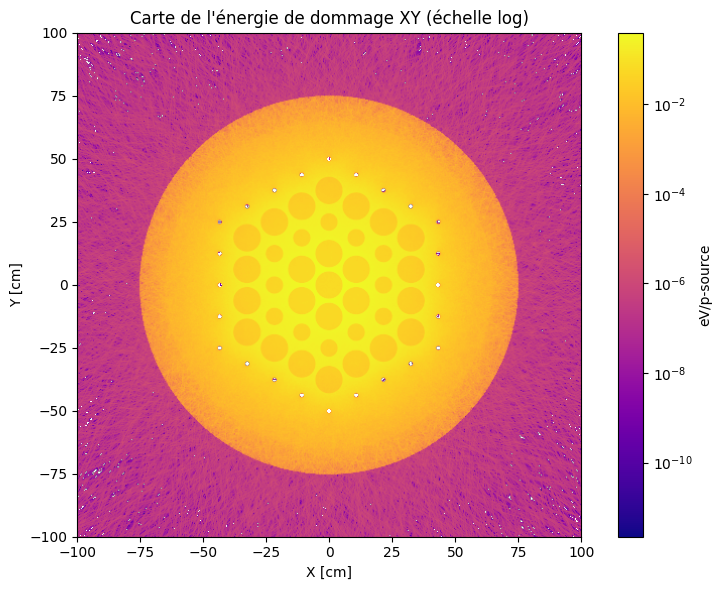

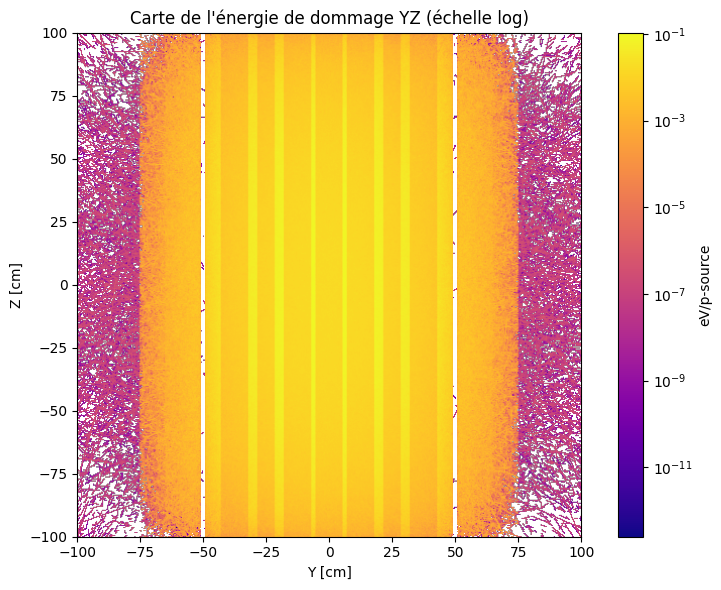

In [26]:
load_dammage_energy_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="dammage_energy_mesh_xy",
                         bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), 
                         zoom_x=(-100, 100), zoom_y=(-100.0, 100.0), plane="xy", saving_figure=False)

load_dammage_energy_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="dammage_energy_mesh_yz",
                         bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), 
                         zoom_x=(-100, 100), zoom_y=(-100.0, 100.0), plane="yz", saving_figure=False)